In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('Dataset_AB_TEST.csv', sep = ';').dropna()

In [5]:
data = data[data['sum_pay'].between(100, 11_000)]
true_points = [1178, 1179, 1182]
data = data[data['id_point'].isin(true_points)]

In [6]:
data.sum_pay.value_counts(bins=[i for i in range(0,12_000,1000)]).reset_index()

,index,sum_pay
0,"(-0.001, 1000.0]",2253
1,"(1000.0, 2000.0]",1512
2,"(3000.0, 4000.0]",1370
3,"(4000.0, 5000.0]",1186
4,"(2000.0, 3000.0]",1150
5,"(6000.0, 7000.0]",901
6,"(5000.0, 6000.0]",775
7,"(7000.0, 8000.0]",683
8,"(8000.0, 9000.0]",233
9,"(9000.0, 10000.0]",128


In [5]:
# импортируем необходимые модули
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

Нам понадобится функция `bootstrap_ab`. Чтобы подготовить данные, давайте посмотрим, какие аргументы она принимает:

Первый аргумент — `test` — массив с данными тестовой группы.

Второй аргумент — `ctrl` — массив с данными контрольной группы.

- отделим только пользователей из тестовой и после контрольной группы
- удалим пустые значения, то есть пользователей, не сделавших покупку
- `.values` превратит серию в массив

In [6]:
test = data[data['id_group'] == 'test']['sum_pay'].dropna().values
# test = data[(data['id_group'] == 'test') & (data['id_point'] == 1178)]['sum_pay'].dropna().values
# test = data[(data['id_group'] == 'test') & (data['id_point'] == 1179)]['sum_pay'].dropna().values
# test = data[(data['id_group'] == 'test') & (data['id_point'] == 1182)]['sum_pay'].dropna().values

In [7]:
ctrl = data[data['id_group'] == 'control']['sum_pay'].dropna().values
# ctrl = data[(data['id_group'] == 'control') & (data['id_point'] == 1178)]['sum_pay'].dropna().values
# ctrl = data[(data['id_group'] == 'control') & (data['id_point'] == 1179)]['sum_pay'].dropna().values
# ctrl = data[(data['id_group'] == 'control') & (data['id_point'] == 1182)]['sum_pay'].dropna().values

Также нам понадобятся аргументы:


- `stat_func = bs_stats.mean` — что мы хотим исследовать. В нашем случае — среднее значение

- `compare_func = bs_compare.difference` — как мы хотим исследовать. В нашем случае — хотим взять разницу между группами

- `return_distribution = True` — вернем набор разниц, который функция получает в результате всех итераций

Чтобы сохранить то, что возвращает функция, запишем результат ее работы в переменную `boot_results`

In [14]:
boot_results = bs.bootstrap_ab(test = test, ctrl = ctrl
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True
                              , num_iterations=55555)

Мы получили массив разниц в средних чеках между нашими группами.

In [15]:
boot_results

array([111.92623537, 227.59345225,  60.08298219, ..., 116.79232264,
       266.88641428, 185.3846157 ])

### Доверительный интервал

Значение среднего чека, которое мы получили для обеих групп, верно только для тех групп пользователей, которые пришли в течение эксперимента. Если бы в эксперименте участвовали похожие, но другие пользователи — значение среднего чека немного, но отличалось бы. Понять, насколько могут отличаться похожие группы в нашем эксперименте, поможет доверительный интервал.

Уровень доверия обычно устанавливают в 95%. То есть можно сказать, что в 95% аналогичных экспериментов конверсия будет колебаться внутри этого интервала. 



**Зададим границы доверительного интервала от 2,5 до 97,5 — между ними как раз 95%.**


Используем полученный выше массив в переменной `boot_results`, чтобы выяснить доверительный интервал — то есть тот интервал колебаний среднего чека похожих экспериментов.

In [16]:
borders = np.percentile(boot_results, [2.5, 97.5]) # считаем перцентили
borders

array([ 52.97899234, 244.07320145])

In [17]:
pd.Series(boot_results).describe(percentiles=[i/10 for i in range(11)]).round(2)

count    55555.00
mean       148.85
std         48.88
min        -76.54
0%         -76.54
10%         86.27
20%        107.65
30%        123.10
40%        136.55
50%        148.96
60%        161.55
70%        174.70
80%        189.95
90%        211.31
100%       362.18
max        362.18
dtype: float64

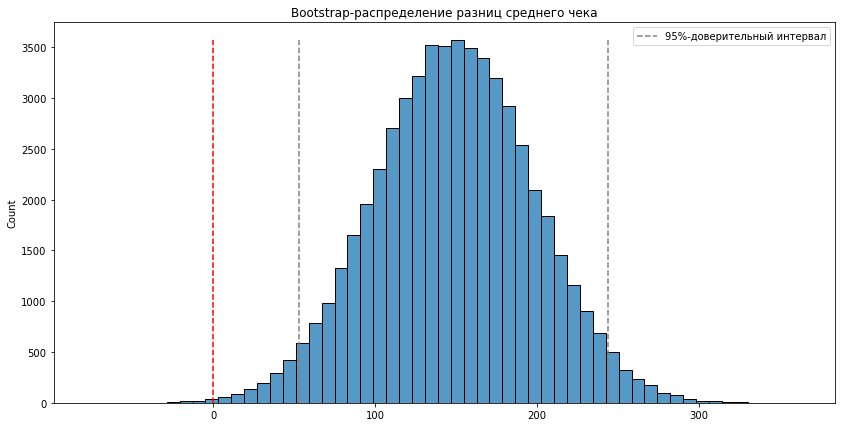

In [26]:
bns = 55 # количество столбцов в гистограмме
sns.histplot(boot_results, bins=bns)  # функция построения распределения
plt.title('Bootstrap-распределение разниц среднего чека')
plt.rcParams["figure.figsize"] = (14, 7)
plt.vlines(0,  # отрисуем линию на уровне ноля
           ymin=0,
           ymax=pd.Series(boot_results).value_counts(bins=bns).max(),
           linestyles='--',
           colors='red')
plt.vlines(borders,  # отрисуем перцентили
           ymin=0,
           ymax=pd.Series(boot_results).value_counts(bins=bns).max(),
           linestyles='--',
           colors='grey',
           label='95%-доверительный интервал')
plt.legend()
plt.savefig("Bootstrap-распределение разниц среднего чека.jpg")
plt.show()